## 20. 프로젝트 : Segmentation map으로 도로 이미지 만들기

이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다.   
**도로의 레이블 정보를 활용해 이미지를 생성**해낸 결과입니다.

<img style='align:center' width='70%' src='https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_result_seg.max-800x600.png'/>

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드할 수 있습니다.
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.

[cityscapes.zip](https://aiffelstaticprd.blob.core.windows.net/media/documents/cityscapes.zip)

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 **레이블 정보 이미지를 입력으로 사용**하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해봅시다.
(아래 튜토리얼은 Pix2Pix 구조를 **Functional API**를 이용해 구현하기 때문에 이번에 진행한 **Subclassing 방법**을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)

[Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)


### 프로젝트 수행
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 **augmentation 방법**을 적용하여 학습해주세요.
(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 **U-Net Generator를 사용**해주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 **"val" 폴더 내 이미지를 사용**해주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 **스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화**해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 **10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨**주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

## 루브릭

|평가문항|	상세기준|
|:-------|:-------|
|1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|
|2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.|U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.|
|3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.|

## 라이브러리 가져오기

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses

from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import image
from tensorflow import data

## 데이터세트 로드하기

In [2]:
# 학습용 이미지 데이터 로드하기
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


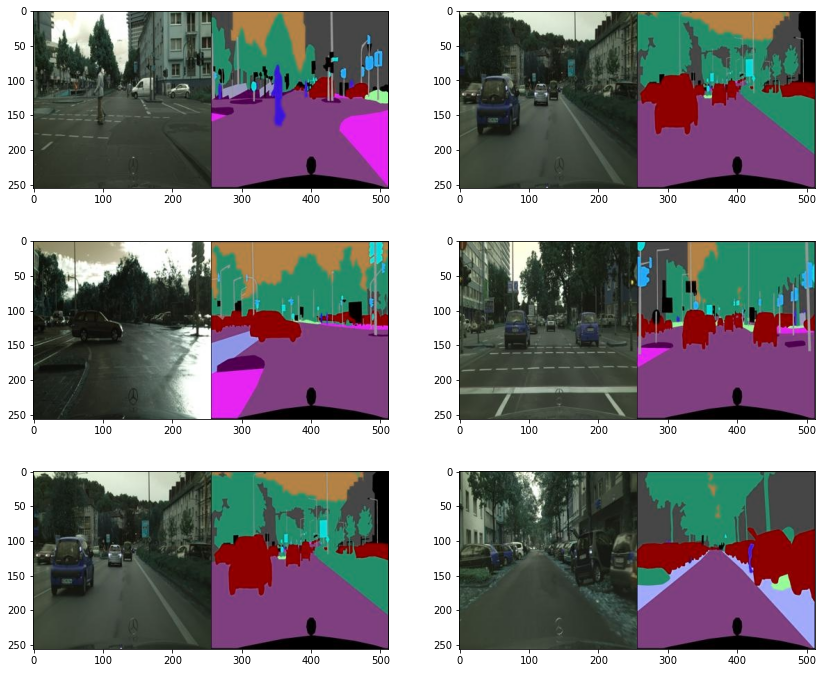

In [3]:
# 학습용 데이터셋에서 임의로 6장을 선택하여 시각화
plt.figure(figsize=(14,12))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(21)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
# 이미지 하나의 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


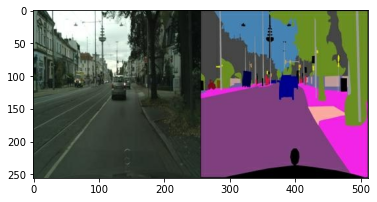

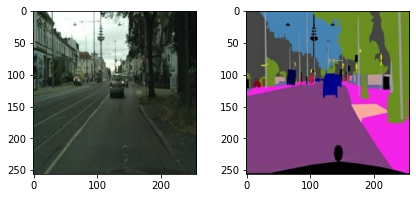

In [5]:
# (256, 256, 3) 크기의 2개 이미지로 분할
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :]                # 원본 이미지 영역
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :]               # segmentation 이미지 영역
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

origin_img = tf.io.read_file(f)
origin_img = tf.image.decode_image(origin_img, 3)
plt.imshow(origin_img)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

* `tf.image.decode_image(img, 3)` :

## Data Augmentation

In [6]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    # 두 이미지가 채널 축으로 연결
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    # 50% 확률로 Refection padding 또는 constant padding
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # 이미지를 임의로 잘라냄
    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)  # 가로로 뒤집기
    out = image.random_flip_up_down(out)     # 세로로 뒤집기
    
    # 50% 확률로 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

* `tf.pad()` :
* `image.random_crop()` :
* `image.random_flip_left_right()` :
* `image.random_flip_up_down()` :
* `tf.random.uniform()` :

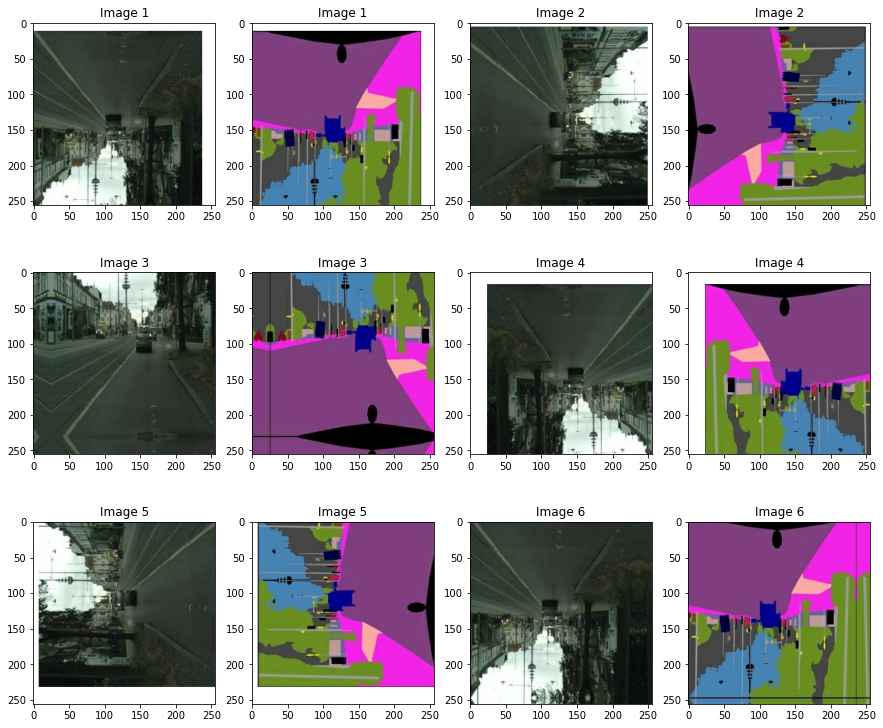

In [7]:
# Data Augmentation 함수 적용해 시각화 

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

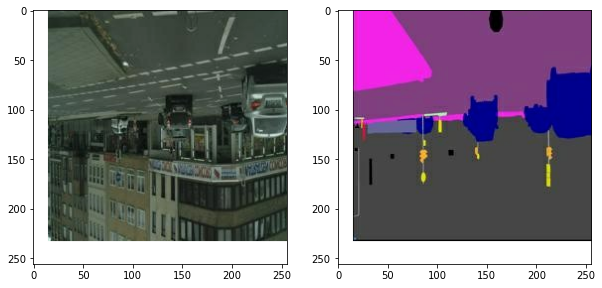

In [8]:
# 잘 적용되었는지 하나의 이미지만 시각화하여 확인

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

* `data.Dataset.list_files()` :

## U-Net generator 구현하기

In [9]:
# Encoder 및 Decoder에 사용되는 기본적인 블록
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, flt, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(flt, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [10]:
# U-Net Generator 정의
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, flt in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(flt, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(flt))
        
        self.decode_blocks = []
        for i, flt in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(flt))
            else:
                self.decode_blocks.append(DecodeBlock(flt, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


* `layers.Conv2DTranspose()` :

In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## Discriminator 구현하기

In [12]:
#  Discriminator에 사용할 기본적인 블록
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [14]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 손실함수 및 최적화 함수 정의

In [15]:
# 손실함수 정의
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [16]:
# 최적화 함수 정의
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [17]:
# 가중치를 1회 업데이트하는 과정
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    # gradient 계산
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    return gene_loss, l1_loss, disc_loss

## 모델 학습 진행

In [18]:
EPOCHS = 150

generator = UNetGenerator()
discriminator = Discriminator()

start = time.time()
history = {'g_loss':[], 'l1_loss':[], 'd_loss':[]:[]}

for epoch in range(1, EPOCHS+1):
    epoch_start = time.time()
    
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)

        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.7070                     
L1_loss:0.2090                     
Discriminator_loss:1.1948

EPOCH[1] - STEP[100]                     
Generator_loss:2.1587                     
L1_loss:0.2363                     
Discriminator_loss:0.5895

EPOCH[1] - STEP[150]                     
Generator_loss:0.9075                     
L1_loss:0.1937                     
Discriminator_loss:0.9113

EPOCH[1] - STEP[200]                     
Generator_loss:1.5377                     
L1_loss:0.2635                     
Discriminator_loss:0.5909

EPOCH[1] - STEP[250]                     
Generator_loss:2.8215                     
L1_loss:0.2095                     
Discriminator_loss:1.0311

EPOCH[2] - STEP[50]                     
Generator_loss:2.1638                     
L1_loss:0.2216                     
Discriminator_loss:0.4616

EPOCH[2] - STEP[100]                     
Generator_loss:1.4348                     
L1_loss:0.2115               

EPOCH[12] - STEP[100]                     
Generator_loss:2.6836                     
L1_loss:0.1769                     
Discriminator_loss:0.3461

EPOCH[12] - STEP[150]                     
Generator_loss:2.5622                     
L1_loss:0.1955                     
Discriminator_loss:0.4703

EPOCH[12] - STEP[200]                     
Generator_loss:2.4688                     
L1_loss:0.1538                     
Discriminator_loss:0.9421

EPOCH[12] - STEP[250]                     
Generator_loss:0.9433                     
L1_loss:0.1828                     
Discriminator_loss:1.1713

EPOCH[13] - STEP[50]                     
Generator_loss:2.3167                     
L1_loss:0.1635                     
Discriminator_loss:1.4780

EPOCH[13] - STEP[100]                     
Generator_loss:1.9259                     
L1_loss:0.1981                     
Discriminator_loss:0.3176

EPOCH[13] - STEP[150]                     
Generator_loss:1.7854                     
L1_loss:0.2002       

EPOCH[23] - STEP[150]                     
Generator_loss:1.4919                     
L1_loss:0.1415                     
Discriminator_loss:0.6089

EPOCH[23] - STEP[200]                     
Generator_loss:2.6239                     
L1_loss:0.1421                     
Discriminator_loss:0.1604

EPOCH[23] - STEP[250]                     
Generator_loss:3.9090                     
L1_loss:0.1683                     
Discriminator_loss:1.5212

EPOCH[24] - STEP[50]                     
Generator_loss:0.9878                     
L1_loss:0.1482                     
Discriminator_loss:0.8671

EPOCH[24] - STEP[100]                     
Generator_loss:2.1569                     
L1_loss:0.1509                     
Discriminator_loss:0.3077

EPOCH[24] - STEP[150]                     
Generator_loss:2.6213                     
L1_loss:0.1790                     
Discriminator_loss:0.1287

EPOCH[24] - STEP[200]                     
Generator_loss:1.3801                     
L1_loss:0.1451       

EPOCH[34] - STEP[200]                     
Generator_loss:2.0320                     
L1_loss:0.1636                     
Discriminator_loss:0.2980

EPOCH[34] - STEP[250]                     
Generator_loss:2.2497                     
L1_loss:0.1691                     
Discriminator_loss:0.2853

EPOCH[35] - STEP[50]                     
Generator_loss:2.0215                     
L1_loss:0.1187                     
Discriminator_loss:0.3088

EPOCH[35] - STEP[100]                     
Generator_loss:2.6217                     
L1_loss:0.1501                     
Discriminator_loss:0.2113

EPOCH[35] - STEP[150]                     
Generator_loss:0.9722                     
L1_loss:0.1302                     
Discriminator_loss:0.6872

EPOCH[35] - STEP[200]                     
Generator_loss:3.0901                     
L1_loss:0.1583                     
Discriminator_loss:0.8189

EPOCH[35] - STEP[250]                     
Generator_loss:3.3727                     
L1_loss:0.1444       

EPOCH[45] - STEP[250]                     
Generator_loss:0.3830                     
L1_loss:0.2077                     
Discriminator_loss:1.5425

EPOCH[46] - STEP[50]                     
Generator_loss:2.0675                     
L1_loss:0.1350                     
Discriminator_loss:0.4180

EPOCH[46] - STEP[100]                     
Generator_loss:1.4628                     
L1_loss:0.1283                     
Discriminator_loss:0.6727

EPOCH[46] - STEP[150]                     
Generator_loss:4.6749                     
L1_loss:0.1477                     
Discriminator_loss:0.0487

EPOCH[46] - STEP[200]                     
Generator_loss:0.5017                     
L1_loss:0.1329                     
Discriminator_loss:1.2747

EPOCH[46] - STEP[250]                     
Generator_loss:3.6654                     
L1_loss:0.1569                     
Discriminator_loss:0.1129

EPOCH[47] - STEP[50]                     
Generator_loss:3.4360                     
L1_loss:0.1244        

EPOCH[57] - STEP[50]                     
Generator_loss:4.9684                     
L1_loss:0.1380                     
Discriminator_loss:0.1892

EPOCH[57] - STEP[100]                     
Generator_loss:2.9188                     
L1_loss:0.1210                     
Discriminator_loss:0.5120

EPOCH[57] - STEP[150]                     
Generator_loss:2.9451                     
L1_loss:0.1342                     
Discriminator_loss:0.5148

EPOCH[57] - STEP[200]                     
Generator_loss:1.9471                     
L1_loss:0.1628                     
Discriminator_loss:0.3611

EPOCH[57] - STEP[250]                     
Generator_loss:3.7194                     
L1_loss:0.1456                     
Discriminator_loss:0.0626

EPOCH[58] - STEP[50]                     
Generator_loss:3.1471                     
L1_loss:0.1195                     
Discriminator_loss:0.4323

EPOCH[58] - STEP[100]                     
Generator_loss:3.2458                     
L1_loss:0.1497        

EPOCH[68] - STEP[100]                     
Generator_loss:3.8398                     
L1_loss:0.0998                     
Discriminator_loss:2.2548

EPOCH[68] - STEP[150]                     
Generator_loss:1.3053                     
L1_loss:0.1560                     
Discriminator_loss:0.5453

EPOCH[68] - STEP[200]                     
Generator_loss:4.9053                     
L1_loss:0.1526                     
Discriminator_loss:0.0847

EPOCH[68] - STEP[250]                     
Generator_loss:3.9412                     
L1_loss:0.1204                     
Discriminator_loss:0.0757

EPOCH[69] - STEP[50]                     
Generator_loss:1.9663                     
L1_loss:0.1409                     
Discriminator_loss:1.2793

EPOCH[69] - STEP[100]                     
Generator_loss:2.6619                     
L1_loss:0.1445                     
Discriminator_loss:0.2878

EPOCH[69] - STEP[150]                     
Generator_loss:4.8054                     
L1_loss:0.1574       

EPOCH[79] - STEP[150]                     
Generator_loss:2.8176                     
L1_loss:0.1248                     
Discriminator_loss:0.1480

EPOCH[79] - STEP[200]                     
Generator_loss:1.9108                     
L1_loss:0.1313                     
Discriminator_loss:0.3172

EPOCH[79] - STEP[250]                     
Generator_loss:3.2580                     
L1_loss:0.1291                     
Discriminator_loss:0.1210

EPOCH[80] - STEP[50]                     
Generator_loss:0.3323                     
L1_loss:0.1380                     
Discriminator_loss:3.2809

EPOCH[80] - STEP[100]                     
Generator_loss:2.6824                     
L1_loss:0.1731                     
Discriminator_loss:0.1790

EPOCH[80] - STEP[150]                     
Generator_loss:4.8736                     
L1_loss:0.1325                     
Discriminator_loss:0.0567

EPOCH[80] - STEP[200]                     
Generator_loss:5.6925                     
L1_loss:0.1337       

EPOCH[90] - STEP[200]                     
Generator_loss:7.1793                     
L1_loss:0.1731                     
Discriminator_loss:2.1892

EPOCH[90] - STEP[250]                     
Generator_loss:2.9810                     
L1_loss:0.1196                     
Discriminator_loss:0.1268

EPOCH[91] - STEP[50]                     
Generator_loss:0.3252                     
L1_loss:0.1637                     
Discriminator_loss:1.6745

EPOCH[91] - STEP[100]                     
Generator_loss:1.8793                     
L1_loss:0.1251                     
Discriminator_loss:0.2590

EPOCH[91] - STEP[150]                     
Generator_loss:2.0565                     
L1_loss:0.1184                     
Discriminator_loss:0.4723

EPOCH[91] - STEP[200]                     
Generator_loss:1.1494                     
L1_loss:0.1363                     
Discriminator_loss:0.6539

EPOCH[91] - STEP[250]                     
Generator_loss:2.9447                     
L1_loss:0.1181       

EPOCH[101] - STEP[250]                     
Generator_loss:0.3886                     
L1_loss:0.1462                     
Discriminator_loss:1.7552

EPOCH[102] - STEP[50]                     
Generator_loss:1.3060                     
L1_loss:0.1332                     
Discriminator_loss:0.7003

EPOCH[102] - STEP[100]                     
Generator_loss:2.1428                     
L1_loss:0.1159                     
Discriminator_loss:0.3119

EPOCH[102] - STEP[150]                     
Generator_loss:5.0577                     
L1_loss:0.1232                     
Discriminator_loss:0.0876

EPOCH[102] - STEP[200]                     
Generator_loss:2.7496                     
L1_loss:0.1489                     
Discriminator_loss:0.2280

EPOCH[102] - STEP[250]                     
Generator_loss:1.8146                     
L1_loss:0.1087                     
Discriminator_loss:0.7026

EPOCH[103] - STEP[50]                     
Generator_loss:2.0594                     
L1_loss:0.1281 

EPOCH[112] - STEP[250]                     
Generator_loss:4.1840                     
L1_loss:0.1394                     
Discriminator_loss:1.0112

EPOCH[113] - STEP[50]                     
Generator_loss:3.4385                     
L1_loss:0.1552                     
Discriminator_loss:0.1107

EPOCH[113] - STEP[100]                     
Generator_loss:4.2457                     
L1_loss:0.1305                     
Discriminator_loss:0.0844

EPOCH[113] - STEP[150]                     
Generator_loss:2.4541                     
L1_loss:0.1313                     
Discriminator_loss:0.1774

EPOCH[113] - STEP[200]                     
Generator_loss:2.1758                     
L1_loss:0.1291                     
Discriminator_loss:0.3570

EPOCH[113] - STEP[250]                     
Generator_loss:2.2003                     
L1_loss:0.1227                     
Discriminator_loss:0.3130

EPOCH[114] - STEP[50]                     
Generator_loss:2.8220                     
L1_loss:0.1143 

EPOCH[123] - STEP[250]                     
Generator_loss:3.0420                     
L1_loss:0.1114                     
Discriminator_loss:0.3577

EPOCH[124] - STEP[50]                     
Generator_loss:3.0094                     
L1_loss:0.1305                     
Discriminator_loss:0.1687

EPOCH[124] - STEP[100]                     
Generator_loss:4.9043                     
L1_loss:0.1459                     
Discriminator_loss:0.0837

EPOCH[124] - STEP[150]                     
Generator_loss:2.7077                     
L1_loss:0.1265                     
Discriminator_loss:0.3754

EPOCH[124] - STEP[200]                     
Generator_loss:3.3503                     
L1_loss:0.1088                     
Discriminator_loss:0.2422

EPOCH[124] - STEP[250]                     
Generator_loss:3.4467                     
L1_loss:0.1234                     
Discriminator_loss:0.1794

EPOCH[125] - STEP[50]                     
Generator_loss:3.4071                     
L1_loss:0.1412 

EPOCH[134] - STEP[250]                     
Generator_loss:2.9657                     
L1_loss:0.1542                     
Discriminator_loss:0.2041

EPOCH[135] - STEP[50]                     
Generator_loss:4.3207                     
L1_loss:0.1315                     
Discriminator_loss:0.0423

EPOCH[135] - STEP[100]                     
Generator_loss:3.0728                     
L1_loss:0.0992                     
Discriminator_loss:0.4523

EPOCH[135] - STEP[150]                     
Generator_loss:6.7903                     
L1_loss:0.1165                     
Discriminator_loss:2.0369

EPOCH[135] - STEP[200]                     
Generator_loss:2.4728                     
L1_loss:0.1035                     
Discriminator_loss:0.2441

EPOCH[135] - STEP[250]                     
Generator_loss:3.6394                     
L1_loss:0.1363                     
Discriminator_loss:0.0645

EPOCH[136] - STEP[50]                     
Generator_loss:2.4401                     
L1_loss:0.1070 

EPOCH[145] - STEP[250]                     
Generator_loss:1.4403                     
L1_loss:0.1093                     
Discriminator_loss:0.4869

EPOCH[146] - STEP[50]                     
Generator_loss:1.7037                     
L1_loss:0.0921                     
Discriminator_loss:0.4961

EPOCH[146] - STEP[100]                     
Generator_loss:4.7566                     
L1_loss:0.1343                     
Discriminator_loss:0.0587

EPOCH[146] - STEP[150]                     
Generator_loss:4.2200                     
L1_loss:0.1898                     
Discriminator_loss:0.0430

EPOCH[146] - STEP[200]                     
Generator_loss:2.1556                     
L1_loss:0.1357                     
Discriminator_loss:0.3600

EPOCH[146] - STEP[250]                     
Generator_loss:1.7931                     
L1_loss:0.1126                     
Discriminator_loss:0.3986

EPOCH[147] - STEP[50]                     
Generator_loss:7.1644                     
L1_loss:0.1491 

## 검증용 데이터세트를 사용하여 생성하기

In [19]:
# 검증용 이미지 데이터 로드하기
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
print("number of train examples :", len(os.listdir(val_path)))

number of train examples : 5


In [22]:
def draw_city(test_ind = 1):
    f = val_path + os.listdir(val_path)[test_ind]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(15,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(colored))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(sketch))

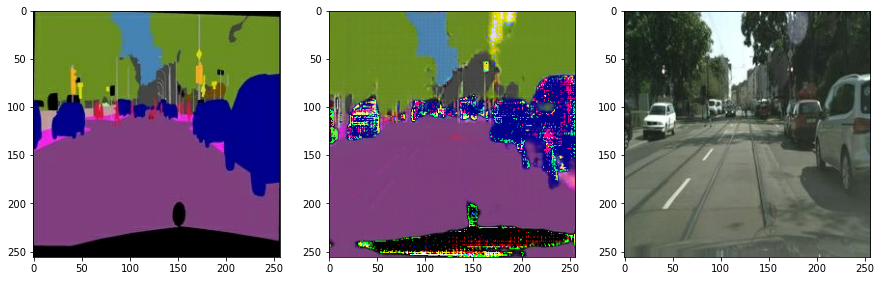

In [28]:
draw_city(test_ind = 0)

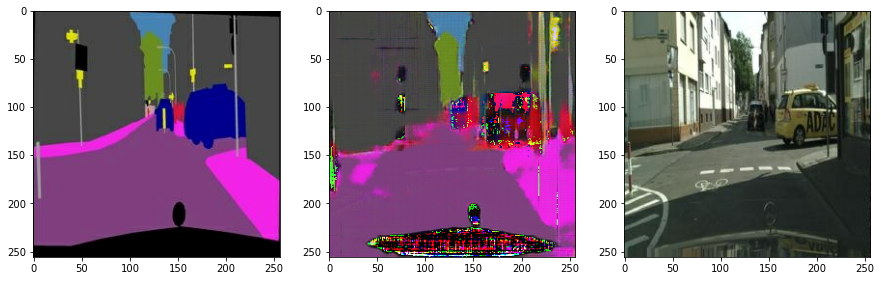

In [29]:
draw_city(test_ind = 1)

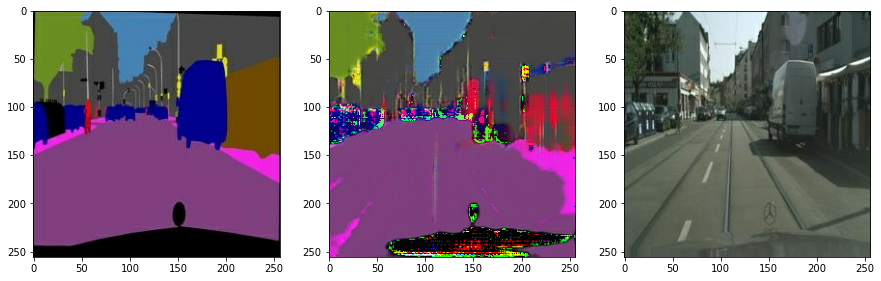

In [30]:
draw_city(test_ind = 2)

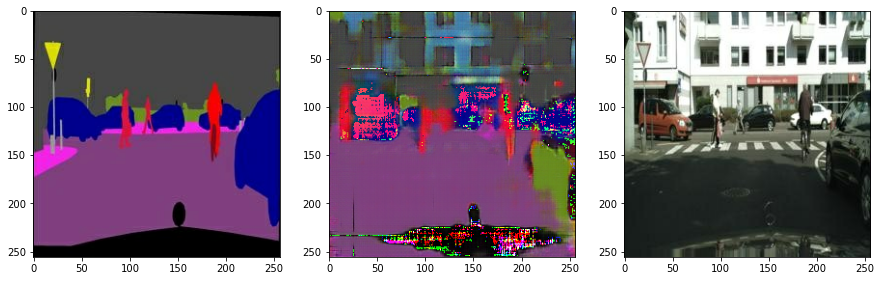

In [31]:
draw_city(test_ind = 3)

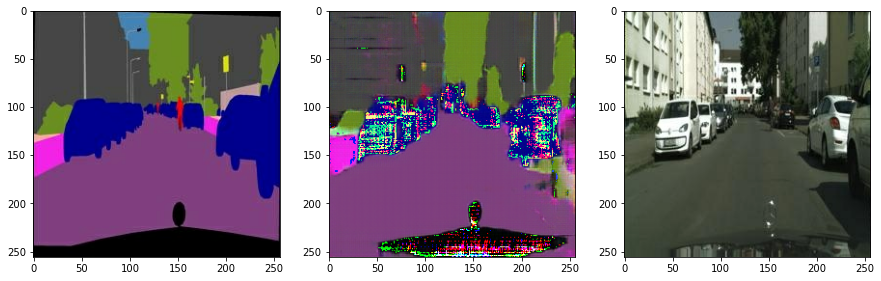

In [32]:
draw_city(test_ind = 4)

## 회고

* U-Net 구조를 이해하는데 어렵다
* 앞으로 해보고 싶은 것 중에 하나가 segmentation 이라서 다시 코드를 천천히 봐야겠다.
* 채색된 결과가 만족스럽지 않다. 
  - 생성기와 판별기의 손실값이 0.5 수렴하지 않아서 발생한 것으로 생각된다.